# 4章 4.2 EGM を用いた TI の準コード（$\delta < 1.0$ の場合）

In [7]:
# パッケージのインポート

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev

### 1. パラメータをカリブレーション

In [8]:
# パラメータをカリブレーション
beta = 0.96
gamma = 1.0
alpha = 0.4
delta = 0.8

### 2. 収束の基準を定義

In [9]:
# 収束の基準を定義
epsilon = 1e-5

### 3. 制御変数のグリッドを生成

- $\{ k^\prime \}_{i = 1}^N, \;\; N = 21$
- $k_1^\prime = 0, k_{21}^\prime = 0.5$

In [10]:
# 制御変数のグリッドを生成
kprime_grid = np.linspace(0.025, 0.5, 20)
print(kprime_grid)

[0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3
 0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5  ]


### 4. $k_i^\prime$ に対応する $m_i^\prime$ を $\tilde{f}(k^\prime_i)$ から求める

- 政策関数 $c_i^\prime = h^{(0)}(k^\prime)$
- 初期値は次期の資本 $k^\prime$ のグリッド * 0.8の値とする

In [11]:
# 次期の m のグリッドを計算
def f_tilde(k: float)-> float:
    return k ** alpha + (1 - delta) * k

np_f_tilde = np.frompyfunc(f_tilde, 1, 1)

mprime_grid = np_f_tilde(kprime_grid)
print(mprime_grid)

[0.23365252596366318 0.31170881682725815 0.36983341038127754
 0.4181071705534973 0.4602752816480621 0.4982054920046205
 0.5329838052704776 0.5653055608807535 0.5956466573774779
 0.6243491774985174 0.651668454455246 0.6778008505674118 0.702901090218769
 0.7270935704911837 0.7504800192603066 0.7731448431551463
 0.7951589618881499 0.8165826204502337 0.8374674928188804
 0.857858283255199]


### 5. 求めた $m_i^\prime$ に対応する $c_i^\prime = h^{(0)}(m_i^\prime)$ を当て推量する

In [12]:
# m'の増加関数とする
h_old_grid = mprime_grid * 0.8 

### 6. 全ての $k^\prime_i$ について $||h^{(new)}(\tilde{f}(k^\prime_i)) - h^{(old)}(\tilde{f}(k^\prime_i))||$ が成り立つまで以下のステップを繰り返す

1.  当て推量された政策関数, もしくは, 前のループで更新された政策関数( $h^{(old)}$とする ) を所与として, 各 $k^\prime_i$ について, 
    1. $c_i = u^{\prime -1} (\beta u^\prime (h^{(old)}(\tilde{f}(k_i^\prime)))\tilde{f}^\prime (k_i^\prime))$ から $c_i$ を得る
    2. $m_i = c_i + k_i^\prime$ から $m_i$ を得る
2. $k_i^\prime$ ごとに得られた $(c_i, \;\; m_i)$ を補間して, 連続な政策関数 $h^{(new)}$ を得る
3. 収束の基準 $\begin{aligned}\max_{k_i^\prime}\{||h^{(new)}(\tilde{f}(k^\prime_i)) - h^{(old)}(\tilde{f}(k^\prime_i))||\} < \varepsilon \end{aligned}$ を計算し, 収束判定する

In [13]:
# ステップ 6 の準備
# - 限界効用関数を定義
def u_prime(c: float)-> float:
    return c ** (-gamma)

# - 限界効用関数の逆関数を定義
def inv_u_prime(mu: float)-> float:
    return mu ** (-gamma)

# -富の関数の微分を定義
def f_tilde_prime(k: float)-> float:
    return alpha * k ** (alpha - 1) + (1 - delta)

# - チェビシェフ多項式を用いた連続な政策関数を計算する関数
def compute_h_new_continuous(c_grid, m_grid):
    # k_gridに対してチェビシェフ多項式のフィッティングを行う
    cheb_fit = Chebyshev.fit(m_grid, c_grid, deg=16) # 次数は適当に16とした
    
    # m のグリッドに対して cのグリッドを返す関数
    h_new = np.frompyfunc(cheb_fit, 1, 1)
    
    return h_new

In [15]:
# ステップ 6 のロジック

diff = 1e-5 + 1.0
loop = 0
while diff > epsilon: 
    loop += 1

    c_grid = np.zeros_like(kprime_grid)
    m_grid = np.zeros_like(kprime_grid)

    for i, kprime in enumerate(kprime_grid):
        # c と m のグリッドを計算
        c_grid[i] = inv_u_prime(beta * u_prime(h_old_grid[i]) * f_tilde_prime(kprime))
        m_grid[i] = kprime_grid[i] + c_grid[i]
    
    # チェビシェフ多項式補間を用いて連続な政策関数を計算
    h_new_func = compute_h_new_continuous(c_grid, m_grid)

    # k' のグリッドに対応する c' の値を計算
    h_new_grid = h_new_func(mprime_grid)
    
    # 収束の基準を計算
    diff = np.max(np.abs(h_new_grid - h_old_grid))
    
    # h_old_grid を更新
    h_old_grid = h_new_grid

print(f"収束までのステップ数: {loop}")

収束までのステップ数: 1


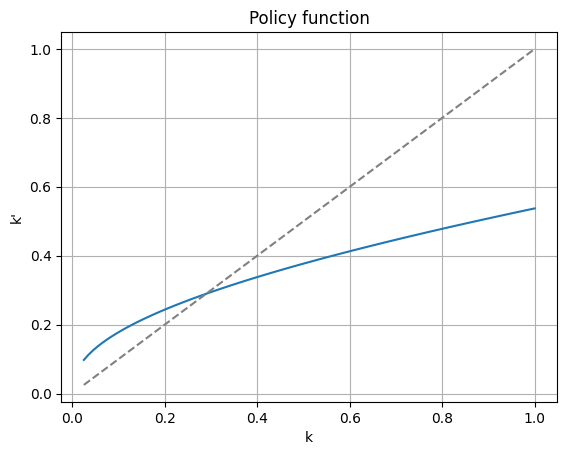

In [17]:
# 政策関数を用いて, k -> k' を計算
k = np.linspace(0.025, 1.0, 100)
m = np_f_tilde(k)
c = h_new_func(m)
kprime = m - c

# 結果のプロット
fig, ax = plt.subplots()
ax.plot(k, kprime, label="Policy function")
ax.plot(k, k, linestyle="--", color="grey")
ax.set(xlabel="k", ylabel="k'", title="Policy function")
ax.grid()
plt.show()